In [4]:
#importing packages and classes from tensorflow to implement LSTM and GRU and SKLearn packages from ML implementation
import seaborn as sns
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
import os

from sentence_transformers import SentenceTransformer #loading bert sentence model
from keras.layers import LSTM #class for LSTM training
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from keras.layers import Bidirectional,GRU #loading GRU and bidirectional model
import pickle


In [5]:
#define minmax scaler class for features normalization
normalized = MinMaxScaler((0, 1))

In [6]:
#create bert model object
bert = SentenceTransformer('nli-distilroberta-base-v2')
print("Bert object initialized")

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

c:\Users\paliv\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\paliv\.cache\huggingface\hub\models--sentence-transformers--nli-distilroberta-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/679 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

RobertaModel LOAD REPORT from: sentence-transformers/nli-distilroberta-base-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Bert object initialized


In [7]:
#load stock prices dataset
dataset = pd.read_csv("Dataset/AAPL.csv")
dataset.fillna(0, inplace = True)
dataset

,Date,Open,High,Low,Close,Adj Close,Volume,Label
0,2012-09-04,95.108574,96.448570,94.928574,96.424286,87.121140,91973000,1
1,2012-09-05,96.510002,96.621429,95.657143,95.747147,86.509338,84093800,0
2,2012-09-06,96.167145,96.898575,95.828575,96.610001,87.288956,97799100,1
3,2012-09-07,96.864288,97.497147,96.538574,97.205711,87.827171,82416600,1
4,2012-09-10,97.207146,97.612854,94.585716,94.677139,85.542564,121999500,0
...,...,...,...,...,...,...,...,...
1253,2017-08-28,160.139999,162.000000,159.929993,161.470001,161.470001,25966000,1
1254,2017-08-29,160.100006,163.119995,160.000000,162.910004,162.910004,29516900,1
1255,2017-08-30,163.800003,163.889999,162.610001,163.350006,163.350006,27269600,1
1256,2017-08-31,163.639999,164.520004,163.479996,164.000000,164.000000,26785100,1


In [8]:
#now load tweets dataset
tweets = pd.read_csv("Dataset/tweets.csv")
tweets

,Tweets,Label
0,RT @philstockworld: Summary of Yesterday's Web...,0
1,iTV Will Boost Apple http://t.co/8dup4cQc08 $A...,0
2,#iPhone users are more intelligent than #Samsu...,0
3,RT @philstockworld: Summary of Yesterday's Web...,0
4,2013 Wrap-Up And Trading Set Review - Part III...,0
...,...,...
1253,RT @engadget: Miss anything from today's #WWDC...,1
1254,RT @carlquintanilla: #WWDC14 TV madness. @CNBC...,1
1255,RT @engadget: Miss anything from today's #WWDC...,1
1256,.@dasan Why not? Everyone loves the idea of a ...,1


In [9]:
#now extract features from tweets using BERT model
if os.path.exists("model/bert.npy"):
    tweets_features = np.load("model/bert.npy")#if tweets features already extarcted then load it 
else:
    #now apply bert model on tweets to extract features and then save the features 
    tweets = tweets['Tweets']
    embeddings = bert.encode(tweets, convert_to_tensor=True)#convert tweets to bert features
    tweets_features = embeddings.numpy()
    np.save("model/bert", tweets_features)
print("Tweets Bert Features")
print(tweets_features)

Tweets Bert Features
[[ 0.47884727 -0.17085582 -0.19215608 ... -0.8593467   0.00342204
   0.5788879 ]
 [ 0.1862817   0.30714378 -0.1579565  ...  0.7503138  -0.01108627
   0.15015505]
 [ 0.3280021   0.267668   -0.10637207 ...  0.7379003  -1.0966189
   0.6128042 ]
 ...
 [ 0.29230827 -0.26123065  0.34682733 ... -0.6132838   0.20073664
   0.6319149 ]
 [ 0.46884552 -0.36563313 -0.33744717 ... -0.16026834  0.05245114
   0.66982824]
 [-0.15445638  0.16994956 -0.25776193 ...  0.10997603 -0.31039646
  -0.13958181]]


In [10]:
#now process dataset by merging both bert features and stock prices data
dataset.drop(['Adj Close','Volume'], axis = 1,inplace=True)
dataset = dataset.values
X = dataset[:,1:dataset.shape[1]-1]
Y = dataset[:,dataset.shape[1]-1]
Y = tweets['Label'].ravel()
#now merge stock prices X and tweets features
X = np.hstack((tweets_features, X))#stacking or merging features
indices = np.arange(X.shape[0])
np.random.shuffle(indices)#shuffle dataset
X = X[indices]
Y = Y[indices]
X = normalized.fit_transform(X)#normalized dataset to 0 and 1
print("Merge & Normalzied features")
print(X)

Merge & Normalzied features
[[0.53405958 0.28235211 0.27902648 ... 0.54039845 0.53993767 0.54886382]
 [0.29196371 0.43398496 0.30079679 ... 0.35551936 0.36372002 0.36421577]
 [0.57972776 0.62354129 0.80693237 ... 0.87464565 0.87405131 0.87964162]
 ...
 [0.61192194 0.33665611 0.54381321 ... 0.34318789 0.35156708 0.3532237 ]
 [0.48911603 0.51826152 0.59304128 ... 0.89244743 0.88491537 0.89368179]
 [0.53485684 0.46497965 0.66464072 ... 0.2680336  0.26647027 0.27023567]]


C:\Users\paliv\AppData\Local\Temp\ipykernel_18480\2827089858.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  Y = tweets['Label'].ravel()


In [11]:
#split dataset into train and test where 80% dataset fro training and 20% for testing
X = X[:,2:X.shape[1]]
X = np.reshape(X, (X.shape[0], 35, 22))#reshaping features as 3 dimensional for LSTM, GRU and Bidirectional training compatible
Y = to_categorical(Y)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)
print()
print("Dataset train & test split as 80% dataset for training and 20% for testing")
print("Training Size (80%): "+str(X_train.shape[0])) #print training and test size
print("Testing Size (20%): "+str(X_test.shape[0]))
print()


Dataset train & test split as 80% dataset for training and 20% for testing
Training Size (80%): 1006
Testing Size (20%): 252



In [12]:
#define global variables to calculate and store accuracy and other metrics
precision = []
recall = []
fscore = []
accuracy = []

In [13]:
#function to calculate various metrics such as accuracy, precision etc
def calculateMetrics(algorithm, predict, testY):
    class_labels = ['Prices will Go Up', 'Prices will go Down']
    p = precision_score(testY, predict,average='macro') * 100
    r = recall_score(testY, predict,average='macro') * 100
    f = f1_score(testY, predict,average='macro') * 100
    a = accuracy_score(testY,predict)*100     
    print()
    print(algorithm+' Accuracy  : '+str(a))
    print(algorithm+' Precision   : '+str(p))
    print(algorithm+' Recall      : '+str(r))
    print(algorithm+' FMeasure    : '+str(f))    
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    conf_matrix = confusion_matrix(testY, predict) 
    plt.figure(figsize =(5, 5)) 
    ax = sns.heatmap(conf_matrix, xticklabels = class_labels, yticklabels = class_labels, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,len(class_labels)])
    plt.title(algorithm+" Confusion matrix") 
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show()

In [19]:
from tensorflow.keras.layers import Input


In [20]:
lstm_model = Sequential()
lstm_model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(LSTM(100))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(100, activation='relu'))
lstm_model.add(Dense(y_train.shape[1], activation='softmax'))

lstm_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

if not os.path.exists("model/lstm_model.h5"):
    checkpoint = ModelCheckpoint(
        'model/lstm_model.h5',
        save_best_only=True,
        verbose=1
    )
    hist = lstm_model.fit(
        X_train, y_train,
        batch_size=16,
        epochs=20,
        validation_data=(X_test, y_test),
        callbacks=[checkpoint]
    )
else:
    lstm_model = load_model("model/lstm_model.h5")


Epoch 1/20
60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5131 - loss: 0.7003
Epoch 1: val_loss improved from None to 0.67650, saving model to model/lstm_model.h5



Epoch 1: finished saving model to model/lstm_model.h5
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5308 - loss: 0.6937 - val_accuracy: 0.5278 - val_loss: 0.6765
Epoch 2/20
59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5496 - loss: 0.6853
Epoch 2: val_loss improved from 0.67650 to 0.66108, saving model to model/lstm_model.h5



Epoch 2: finished saving model to model/lstm_model.h5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5577 - loss: 0.6819 - val_accuracy: 0.5357 - val_loss: 0.6611
Epoch 3/20
57/63 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6091 - loss: 0.6654
Epoch 3: val_loss improved from 0.66108 to 0.61131, saving model to model/lstm_model.h5



Epoch 3: finished saving model to model/lstm_model.h5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6133 - loss: 0.6564 - val_accuracy: 0.6587 - val_loss: 0.6113
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6311 - loss: 0.6467
Epoch 4: val_loss improved from 0.61131 to 0.56613, saving model to model/lstm_model.h5



Epoch 4: finished saving model to model/lstm_model.h5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6501 - loss: 0.6330 - val_accuracy: 0.6746 - val_loss: 0.5661
Epoch 5/20
59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6883 - loss: 0.5866
Epoch 5: val_loss improved from 0.56613 to 0.54686, saving model to model/lstm_model.h5



Epoch 5: finished saving model to model/lstm_model.h5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6730 - loss: 0.5987 - val_accuracy: 0.7738 - val_loss: 0.5469
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7174 - loss: 0.5661
Epoch 6: val_loss did not improve from 0.54686
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7078 - loss: 0.5602 - val_accuracy: 0.7222 - val_loss: 0.5623
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7028 - loss: 0.5739
Epoch 7: val_loss improved from 0.54686 to 0.46949, saving model to model/lstm_model.h5



Epoch 7: finished saving model to model/lstm_model.h5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7207 - loss: 0.5541 - val_accuracy: 0.7937 - val_loss: 0.4695
Epoch 8/20
59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7125 - loss: 0.5430
Epoch 8: val_loss did not improve from 0.46949
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7276 - loss: 0.5357 - val_accuracy: 0.7817 - val_loss: 0.4812
Epoch 9/20
59/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7416 - loss: 0.5248
Epoch 9: val_loss improved from 0.46949 to 0.44406, saving model to model/lstm_model.h5



Epoch 9: finished saving model to model/lstm_model.h5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7396 - loss: 0.5244 - val_accuracy: 0.8016 - val_loss: 0.4441
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7738 - loss: 0.4807
Epoch 10: val_loss improved from 0.44406 to 0.43894, saving model to model/lstm_model.h5



Epoch 10: finished saving model to model/lstm_model.h5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7664 - loss: 0.4964 - val_accuracy: 0.7897 - val_loss: 0.4389
Epoch 11/20
60/63 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7573 - loss: 0.4888
Epoch 11: val_loss improved from 0.43894 to 0.42983, saving model to model/lstm_model.h5



Epoch 11: finished saving model to model/lstm_model.h5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7575 - loss: 0.5029 - val_accuracy: 0.7976 - val_loss: 0.4298
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7981 - loss: 0.4615
Epoch 12: val_loss did not improve from 0.42983
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7793 - loss: 0.4752 - val_accuracy: 0.8016 - val_loss: 0.4652
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7880 - loss: 0.4680
Epoch 13: val_loss did not improve from 0.42983
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7833 - loss: 0.4650 - val_accuracy: 0.7817 - val_loss: 0.4409
Epoch 14/20
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7754 - loss: 0.4827
Epoch 14: val_loss did not improve from 0.42983
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7863 - loss: 0.4774 - val_accuracy: 0.7897 - val_loss: 0.4444
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7872 - loss: 


Epoch 18: finished saving model to model/lstm_model.h5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7783 - loss: 0.4811 - val_accuracy: 0.8056 - val_loss: 0.4211
Epoch 19/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7919 - loss: 0.4512
Epoch 19: val_loss did not improve from 0.42106
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7823 - loss: 0.4641 - val_accuracy: 0.7937 - val_loss: 0.4243
Epoch 20/20
58/63 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8043 - loss: 0.4272
Epoch 20: val_loss did not improve from 0.42106
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8022 - loss: 0.4340 - val_accuracy: 0.8056 - val_loss: 0.4224


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5351 - loss: 0.7017
Epoch 1: val_loss improved from None to 0.69140, saving model to model/propose_model.h5



Epoch 1: finished saving model to model/propose_model.h5
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.5229 - loss: 0.7014 - val_accuracy: 0.5278 - val_loss: 0.6914
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5064 - loss: 0.6986
Epoch 2: val_loss did not improve from 0.69140
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5199 - loss: 0.6958 - val_accuracy: 0.5278 - val_loss: 0.6919
Epoch 3/20
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5244 - loss: 0.6951
Epoch 3: val_loss improved from 0.69140 to 0.68695, saving model to model/propose_model.h5



Epoch 3: finished saving model to model/propose_model.h5
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.5189 - loss: 0.6949 - val_accuracy: 0.5278 - val_loss: 0.6869
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5180 - loss: 0.6908
Epoch 4: val_loss improved from 0.68695 to 0.68621, saving model to model/propose_model.h5



Epoch 4: finished saving model to model/propose_model.h5
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.5288 - loss: 0.6918 - val_accuracy: 0.4762 - val_loss: 0.6862
Epoch 5/20
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5122 - loss: 0.6894
Epoch 5: val_loss improved from 0.68621 to 0.68430, saving model to model/propose_model.h5



Epoch 5: finished saving model to model/propose_model.h5
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.5586 - loss: 0.6855 - val_accuracy: 0.5278 - val_loss: 0.6843
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6082 - loss: 0.6654
Epoch 6: val_loss improved from 0.68430 to 0.58121, saving model to model/propose_model.h5



Epoch 6: finished saving model to model/propose_model.h5
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.6392 - loss: 0.6491 - val_accuracy: 0.6548 - val_loss: 0.5812
Epoch 7/20
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7220 - loss: 0.5657
Epoch 7: val_loss improved from 0.58121 to 0.50264, saving model to model/propose_model.h5



Epoch 7: finished saving model to model/propose_model.h5
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7217 - loss: 0.5635 - val_accuracy: 0.7778 - val_loss: 0.5026
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7381 - loss: 0.5297
Epoch 8: val_loss improved from 0.50264 to 0.47501, saving model to model/propose_model.h5



Epoch 8: finished saving model to model/propose_model.h5
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.7416 - loss: 0.5079 - val_accuracy: 0.7659 - val_loss: 0.4750
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7543 - loss: 0.4986
Epoch 9: val_loss improved from 0.47501 to 0.45109, saving model to model/propose_model.h5



Epoch 9: finished saving model to model/propose_model.h5
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.7575 - loss: 0.5049 - val_accuracy: 0.7659 - val_loss: 0.4511
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7818 - loss: 0.4606
Epoch 10: val_loss did not improve from 0.45109
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.7753 - loss: 0.4710 - val_accuracy: 0.7698 - val_loss: 0.4712
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7708 - loss: 0.4716
Epoch 11: val_loss did not improve from 0.45109
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.7763 - loss: 0.4745 - val_accuracy: 0.7698 - val_loss: 0.4780
Epoch 12/20
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7687 - loss: 0.5065
Epoch 12: val_loss improved from 0.45109 to 0.43280, saving model to model/propose_model.h5



Epoch 12: finished saving model to model/propose_model.h5
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.7684 - loss: 0.4899 - val_accuracy: 0.7817 - val_loss: 0.4328
Epoch 13/20
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7793 - loss: 0.4812
Epoch 13: val_loss did not improve from 0.43280
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.7744 - loss: 0.4758 - val_accuracy: 0.7897 - val_loss: 0.4497
Epoch 14/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7696 - loss: 0.4952
Epoch 14: val_loss did not improve from 0.43280
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.7744 - loss: 0.4747 - val_accuracy: 0.7897 - val_loss: 0.4550
Epoch 15/20
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7836 - loss: 0.4555
Epoch 15: val_loss improved from 0.43280 to 0.41689, saving model to model/propose_model.h5



Epoch 15: finished saving model to model/propose_model.h5
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.7893 - loss: 0.4538 - val_accuracy: 0.8016 - val_loss: 0.4169
Epoch 16/20
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7725 - loss: 0.4610
Epoch 16: val_loss did not improve from 0.41689
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7972 - loss: 0.4473 - val_accuracy: 0.7897 - val_loss: 0.4301
Epoch 17/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7788 - loss: 0.4552
Epoch 17: val_loss improved from 0.41689 to 0.40885, saving model to model/propose_model.h5



Epoch 17: finished saving model to model/propose_model.h5
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7982 - loss: 0.4346 - val_accuracy: 0.8056 - val_loss: 0.4088
Epoch 18/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8017 - loss: 0.4296
Epoch 18: val_loss did not improve from 0.40885
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8002 - loss: 0.4264 - val_accuracy: 0.7857 - val_loss: 0.4644
Epoch 19/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7958 - loss: 0.4417
Epoch 19: val_loss did not improve from 0.40885
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8151 - loss: 0.3990 - val_accuracy: 0.7976 - val_loss: 0.4216
Epoch 20/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8097 - loss: 0.4102
Epoch 20: val_loss did not improve from 0.40885
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.7962 - loss: 0.4417 - val_accuracy: 0.7976 - val_loss: 0.4208
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step

Hybrid Information Missing Module (

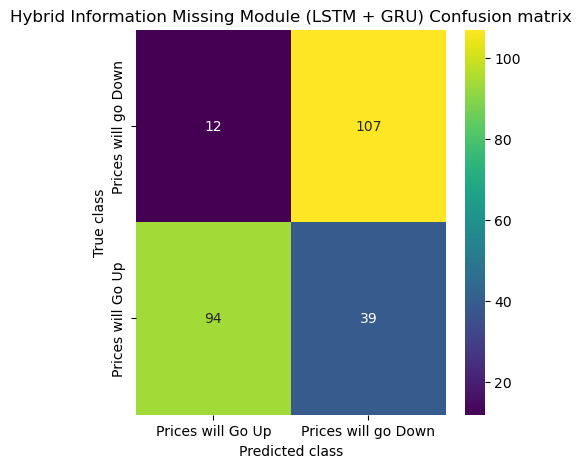

In [22]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
import os, pickle
import numpy as np

# Hybrid LSTM-GRU model
lstm_gru = Sequential()

# Input layer
lstm_gru.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

# LSTM for sequence feature extraction (BERT features assumed sequential)
lstm_gru.add(LSTM(100, return_sequences=True))
lstm_gru.add(Dropout(0.2))

# GRU layers
lstm_gru.add(GRU(80, return_sequences=True))
lstm_gru.add(Dropout(0.2))

lstm_gru.add(GRU(64))
lstm_gru.add(Dropout(0.2))

# MLP layers
lstm_gru.add(Dense(100, activation='relu'))
lstm_gru.add(Dense(y_train.shape[1], activation='softmax'))

# Compile
lstm_gru.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train or load model
if not os.path.exists("model/propose_model.h5"):
    checkpoint = ModelCheckpoint(
        filepath="model/propose_model.h5",
        save_best_only=True,
        verbose=1
    )

    hist = lstm_gru.fit(
        X_train, y_train,
        batch_size=16,
        epochs=20,
        validation_data=(X_test, y_test),
        callbacks=[checkpoint],
        verbose=1
    )

    with open('model/propose_history.pckl', 'wb') as f:
        pickle.dump(hist.history, f)
else:
    lstm_gru = load_model("model/propose_model.h5")

# Prediction
predict = lstm_gru.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)

calculateMetrics(
    "Hybrid Information Missing Module (LSTM + GRU)",
    predict,
    y_test1
)


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5469 - loss: 0.6947
Epoch 1: val_loss improved from None to 0.68112, saving model to model/extension_model.h5



Epoch 1: finished saving model to model/extension_model.h5
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.5298 - loss: 0.6966 - val_accuracy: 0.5397 - val_loss: 0.6811
Epoch 2/20
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5639 - loss: 0.6751
Epoch 2: val_loss improved from 0.68112 to 0.55124, saving model to model/extension_model.h5



Epoch 2: finished saving model to model/extension_model.h5
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.5915 - loss: 0.6585 - val_accuracy: 0.7778 - val_loss: 0.5512
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7176 - loss: 0.5508
Epoch 3: val_loss improved from 0.55124 to 0.43606, saving model to model/extension_model.h5



Epoch 3: finished saving model to model/extension_model.h5
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.7217 - loss: 0.5455 - val_accuracy: 0.7976 - val_loss: 0.4361
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7847 - loss: 0.4827
Epoch 4: val_loss improved from 0.43606 to 0.39873, saving model to model/extension_model.h5



Epoch 4: finished saving model to model/extension_model.h5
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.7833 - loss: 0.4873 - val_accuracy: 0.8214 - val_loss: 0.3987
Epoch 5/20
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7707 - loss: 0.4654
Epoch 5: val_loss did not improve from 0.39873
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.7853 - loss: 0.4721 - val_accuracy: 0.8175 - val_loss: 0.4074
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7884 - loss: 0.4657
Epoch 6: val_loss did not improve from 0.39873
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.7962 - loss: 0.4586 - val_accuracy: 0.8294 - val_loss: 0.4068
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7897 - loss: 0.4610
Epoch 7: val_loss improved from 0.39873 to 0.39145, saving model to model/extension_model.h5



Epoch 7: finished saving model to model/extension_model.h5
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.8052 - loss: 0.4451 - val_accuracy: 0.8214 - val_loss: 0.3915
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8145 - loss: 0.4511
Epoch 8: val_loss improved from 0.39145 to 0.38665, saving model to model/extension_model.h5



Epoch 8: finished saving model to model/extension_model.h5
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.8111 - loss: 0.4374 - val_accuracy: 0.8175 - val_loss: 0.3866
Epoch 9/20
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8109 - loss: 0.4167
Epoch 9: val_loss did not improve from 0.38665
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.8062 - loss: 0.4413 - val_accuracy: 0.8294 - val_loss: 0.3892
Epoch 10/20
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8138 - loss: 0.4321
Epoch 10: val_loss improved from 0.38665 to 0.37810, saving model to model/extension_model.h5



Epoch 10: finished saving model to model/extension_model.h5
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.8091 - loss: 0.4208 - val_accuracy: 0.8254 - val_loss: 0.3781
Epoch 11/20
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7886 - loss: 0.4565
Epoch 11: val_loss did not improve from 0.37810
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.8082 - loss: 0.4274 - val_accuracy: 0.8214 - val_loss: 0.3826
Epoch 12/20
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8217 - loss: 0.4180
Epoch 12: val_loss improved from 0.37810 to 0.35352, saving model to model/extension_model.h5



Epoch 12: finished saving model to model/extension_model.h5
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.8260 - loss: 0.4164 - val_accuracy: 0.8333 - val_loss: 0.3535
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8241 - loss: 0.3953
Epoch 13: val_loss did not improve from 0.35352
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.8141 - loss: 0.4131 - val_accuracy: 0.8333 - val_loss: 0.3696
Epoch 14/20
62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8182 - loss: 0.4038
Epoch 14: val_loss did not improve from 0.35352
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.8091 - loss: 0.4196 - val_accuracy: 0.8294 - val_loss: 0.3697
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8220 - loss: 0.3997
Epoch 15: val_loss did not improve from 0.35352
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.8101 - loss: 0.4150 - val_accuracy: 0.8175 - val_loss: 0.3858
Epoch 16/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8111 - 

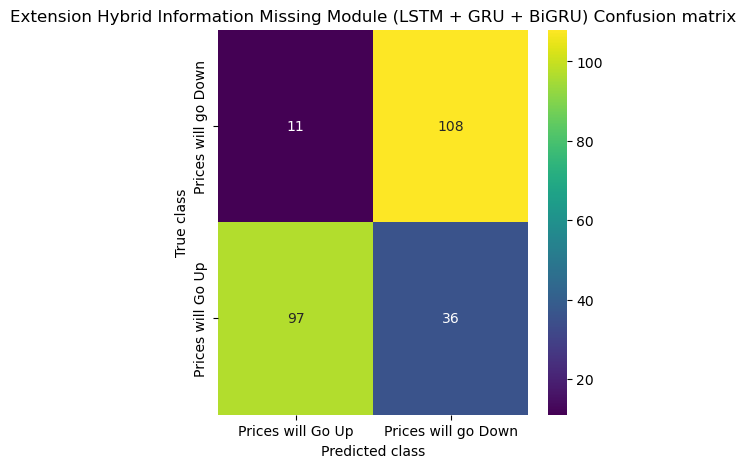

In [24]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import os, pickle
import numpy as np

# Enhanced Extension Hybrid Model with improved architecture
extension_model = Sequential()

# Input layer
extension_model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

# Bidirectional LSTM layer for better temporal pattern capture
extension_model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001))))
extension_model.add(BatchNormalization())
extension_model.add(Dropout(0.3))

# First Bidirectional GRU layer
extension_model.add(Bidirectional(GRU(96, return_sequences=True, kernel_regularizer=l2(0.001))))
extension_model.add(BatchNormalization())
extension_model.add(Dropout(0.3))

# Second Bidirectional GRU layer
extension_model.add(Bidirectional(GRU(64, kernel_regularizer=l2(0.001))))
extension_model.add(BatchNormalization())
extension_model.add(Dropout(0.3))

# Enhanced dense layers
extension_model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
extension_model.add(BatchNormalization())
extension_model.add(Dropout(0.3))
extension_model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
extension_model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile
extension_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train or load model
if not os.path.exists("model/extension_model.h5"):
    checkpoint = ModelCheckpoint(
        filepath='model/extension_model.h5',
        save_best_only=True,
        monitor='val_accuracy',
        mode='max',
        verbose=1
    )
    
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    hist = extension_model.fit(
        X_train, y_train,
        batch_size=16,
        epochs=50,
        validation_data=(X_test, y_test),
        callbacks=[checkpoint, early_stopping, reduce_lr],
        verbose=1
    )

    with open('model/extension_history.pckl', 'wb') as f:
        pickle.dump(hist.history, f)
else:
    extension_model = load_model("model/extension_model.h5")

# Prediction
predict = extension_model.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)

calculateMetrics(
    "Extension Hybrid Information Missing Module (LSTM + GRU + BiGRU)",
    predict,
    y_test1
)


In [30]:
def calculateMetrics(name, y_pred, y_true):
    p = precision_score(y_true, y_pred)
    r = recall_score(y_true, y_pred)
    f = f1_score(y_true, y_pred)
    a = accuracy_score(y_true, y_pred)

    print(name, "Accuracy  :", a)
    print(name, "Precision :", p)
    print(name, "Recall    :", r)
    print(name, "FMeasure  :", f)

    return p, r, f, a


In [32]:
pred_lstm = lstm_model.predict(X_test)
pred_lstm = np.argmax(pred_lstm, axis=1)
pred_hybrid = lstm_gru.predict(X_test)
pred_hybrid = np.argmax(pred_hybrid, axis=1)
pred_extension = extension_model.predict(X_test)
pred_extension = np.argmax(pred_extension, axis=1)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [33]:
precision, recall, fscore, accuracy = [], [], [], []

# Existing LSTM
p, r, f, a = calculateMetrics("Existing LSTM", pred_lstm, y_test1)
precision.append(p); recall.append(r); fscore.append(f); accuracy.append(a)

# Proposed Hybrid
p, r, f, a = calculateMetrics("Proposed Hybrid Information Missing Module",
                             pred_hybrid, y_test1)
precision.append(p); recall.append(r); fscore.append(f); accuracy.append(a)

# Extension Hybrid
p, r, f, a = calculateMetrics("Extension Bidirectional Hybrid Information Missing Module",
                             pred_extension, y_test1)
precision.append(p); recall.append(r); fscore.append(f); accuracy.append(a)


Existing LSTM Accuracy  : 0.8055555555555556
Existing LSTM Precision : 0.7651515151515151
Existing LSTM Recall    : 0.8487394957983193
Existing LSTM FMeasure  : 0.8047808764940239
Proposed Hybrid Information Missing Module Accuracy  : 0.7976190476190477
Proposed Hybrid Information Missing Module Precision : 0.7328767123287672
Proposed Hybrid Information Missing Module Recall    : 0.8991596638655462
Proposed Hybrid Information Missing Module FMeasure  : 0.8075471698113208
Extension Bidirectional Hybrid Information Missing Module Accuracy  : 0.8134920634920635
Extension Bidirectional Hybrid Information Missing Module Precision : 0.75
Extension Bidirectional Hybrid Information Missing Module Recall    : 0.907563025210084
Extension Bidirectional Hybrid Information Missing Module FMeasure  : 0.8212927756653993


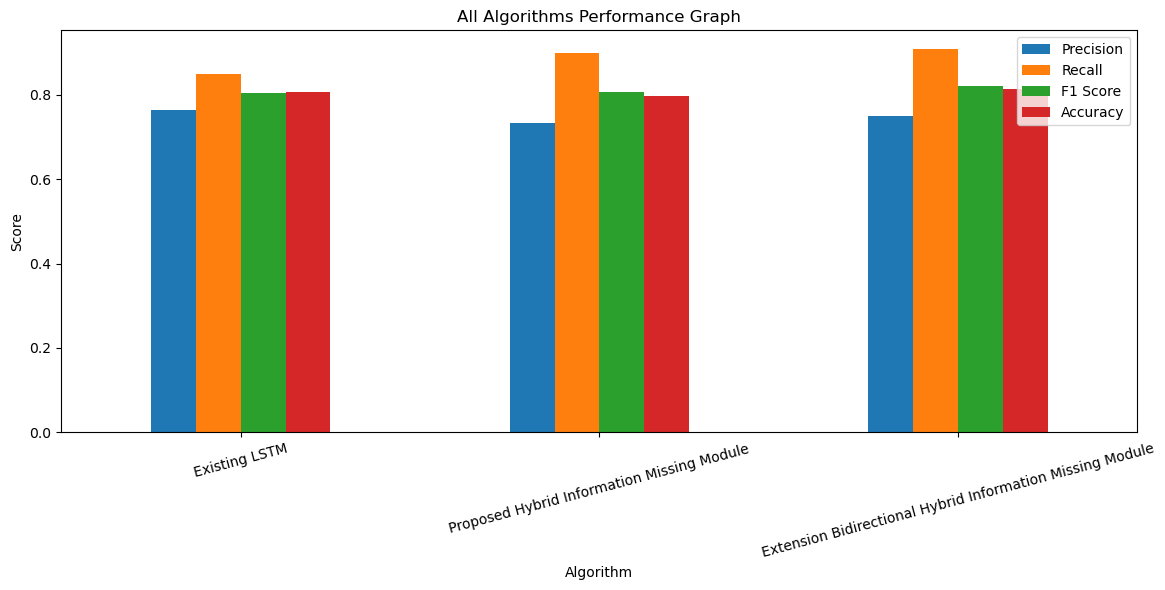

In [34]:
df = pd.DataFrame({
    'Algorithm': [
        'Existing LSTM',
        'Proposed Hybrid Information Missing Module',
        'Extension Bidirectional Hybrid Information Missing Module'
    ],
    'Precision': precision,
    'Recall': recall,
    'F1 Score': fscore,
    'Accuracy': accuracy
})

df.set_index('Algorithm').plot(kind='bar', figsize=(12,6))
plt.title("All Algorithms Performance Graph")
plt.ylabel("Score")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


In [35]:
results_df = pd.DataFrame({
    "Algorithm Name": algorithm_names,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": fscore,
    "Accuracy": accuracy
})

results_df


,Algorithm Name,Precision,Recall,F1 Score,Accuracy
0,Existing LSTM,0.765152,0.848739,0.804781,0.805556
1,Propose Hybrid Information Mising Module,0.732877,0.899160,0.807547,0.797619
2,Extension Bidirectional Hybrid Information Mis...,0.750000,0.907563,0.821293,0.813492


In [36]:
class_labels = ['Prices will Go Up', 'Prices will go Down']
test_stock = pd.read_csv("Dataset/test_stock.csv")#read stock values
test_tweets = pd.read_csv("Dataset/test_tweets.csv") #read tweets
stocks = test_stock.values
stock = stocks[:,1:stocks.shape[1]]#read all stock data as array
tweets = test_tweets['Tweets']
embeddings = bert.encode(tweets, convert_to_tensor=True)#convert tweets to bert features
tweets_features = embeddings.numpy()
X = np.hstack((tweets_features, stock))#merge both stock and tweets features
X = normalized.transform(X)#normalized dataset to 0 and 1
X = X[:,2:X.shape[1]]
X = np.reshape(X, (X.shape[0], 35, 22))#reshape data as 3 dimensional so compatible with GRU, LSTM and bidrirectional
predict = extension_model.predict(X)#perform prediction using extension model for prices
for i in range(len(predict)):#display output values
    y_pred = np.argmax(predict[i])
    print("Tweet : "+tweets[i])
    print("Stock Price : "+str(stocks[i]))
    print("Stock Movement Prediction ====> "+class_labels[y_pred])
    print()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Tweet : $AAPL   excellent short on my part,  mentioned earlier. I don't always mention intraday trades, to busy
Stock Price : ['2013-01-09' 74.64286 75.001427 73.71285999999999 73.871429]
Stock Movement Prediction ====> Prices will go Down

Tweet : Bad sales at $SHLD. $SNE streaming games. $AAPL streaming everything$AMZN selling everything. Should anyone own $BBY here? @jimcramer
Stock Price : ['2013-01-10' 75.507141 75.531425 73.645714 72.78714000000001]
Stock Movement Prediction ====> Prices will go Down

Tweet : RT @PeterGhostine: I guess Carl needs to buy antoher tranche of $AAPL. Sold the 552.50/555 call spread on my private stream today.
Stock Price : ['2013-01-11' 74.428574 75.045715 74.145714 74.328575]
Stock Movement Prediction ====> Prices will Go Up

Tweet : $AAPL a secret SuperBowl commercial would be an awesome surprise for Apple to tease a TV device with most of America watching. If only!
Stock Price : ['2013-01-14' 71.811432 72.5 71.